---
title: Clustering
format:
  html:
    css: "styles.css"
    embed-resources: true
    code-fold: true
bibliography: "Quarto_website.bib"
---

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MeanShift
from sklearn.cluster import Birch
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances, silhouette_score
import warnings
import pandas as pd

In [ ]:
df=pd.read_csv('../../data/Clean_Data_project_Pub.Transport_5000/EPA_SmartLocationDatabase_V3_Jan_2021_Clean.csv')

scaler = StandardScaler()
df_scaled = (scaler.fit_transform(df))
df_scaled=pd.DataFrame(df_scaled)

## Explanation of clustering methods
Clustering focuses on finding unknown similarities or groupings in the data (unsupervised). The goal is to see if there are any groupings in a given data set in order to make generalizations about the data. The data set used for this project is the EPA Smart Location Database (EPA_SmartLocationDatabase_V3_Jan_2021_Clean.csv in the clean data folder), which contains census block data for the US. The data set contains 71 variables and 220740 census blocks, which will be used for clustering. Every explanation of each variable can be found in the raw data folder under the EPA_SLD_3.0_TechnicalDocumentationUserGuide_May2021.pdf or in the following citation [@EPA_Variables]. There are three methods that will be used for this study: K-means, Hierarchical, and DBSCAN. The goal is to see if there are any groupings in the data in order to make generalizations about these census blocks. If there is a small enough group of groupings, we can make generalizations about the census blocks use them for public transportation planning.

### K-means
K-means is a clustering method that focuses on finding the centers of the clusters and then assigning the data points to each cluster. The number of clusters is chosen by the performer, so the work around is to provide a range of possible number of clusters and get their scores in order to find the most optimal one. The algorithm randomly selects k points in the data, calculates the center of the cluster, and then assigns each point to the closest cluster. The algorithm is heavily impacted by the initial random points selected, so the algorithm is run multiple times and the best result is selected for the number of clusters specified. Furthermore, in order to get more accruacy, the data is scaled before running this algorithm as it is extreamly sensitive to outliers.

### DBSCAN
DBSCAN is another clustering method that tries to find clusters based on the density (distances between points and a minimum number of points). It also detects and marks outliers as points that are in very low density regions. The algorithm runs until all points are placed in a cluster or marked as an outlier. Then, the best result is selected. The algorithm is also sensitive to outliers the same way as k-means, so the data set is scaled to reduce the effect of outliers.

DBSCAN requires two parameters: epsilon and minimum samples. Epsilon is the maximum distance between two points in order for them to be considered in the same cluster. The Minimum sample is the minimum number of points in each cluster. In order to find the best parameters, the algorithm is run multiple times with different values for epsilon and minimum samples. The best result is then selected.

### Hierarchical Clustering
Hierarchical clustering is a clustering method that focuses on finding clusters based on distance. The algorithm works by finding the two closest points in the data set and forming a cluster. The distance between the two points is the distance between the two clusters. The algorithm is repeated until all the points are assigned to a cluster. The algorithm is sensitive to the distance, so the algorithm is run multiple times with different values for the distance. The best result is selected. The algorithm is also sensitive to outliers, so the data set is scaled to reduce the effect of outliers.

Hierarchical clustering is a method that finds the clusters based on distance. The algorithm works by finding the two closest points in the data set and forming a cluster. The algorithm is repeated until all points are assigned to a cluster. Thus, the algorithm runs multiple times with different values for the distance and then the best result is selected. As the previous two, the algorithm is also sensitive to outliers, so the data set is scaled to reduce the effect of outliers.

### Scores used:
- Distortion: Distortion is the sum of squared errors. It can be used empirically to find the optimal number of clusters by plotting the distortion for each number of clusters and finding the elbow point. 
- Davies-Boulding Index: This index is the average of the ratios of of all clusters. Each cluster ratio is the average distance between points in a cluster and the centroid of the cluster to the distance between the centroids of the cluster and the nearest cluster. The lower the index, the better the clustering [@Davies_boulding_index].
- Other options that have been rejected: Due to the size of the data set, the Silhouette Score and Inertia where discard. These scores were either too computationaly expensive or not suitable for the data set.

## k-means++

These are the following scores obtained per number of clusters in k-means++. We will only use distortion as our parameter due to the large size of our data set and my laptop's computational limitations. Thus, we will use the elbow method to empirically find the optimal number of clusters.

In [ ]:
distortion_values = []

for i in range(1, 65):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_scaled)
    cluster_assignments = kmeans.predict(df_scaled)
    centers = kmeans.cluster_centers_

    distortion = sum(np.min(pairwise_distances(df_scaled, centers, metric='euclidean'), axis=1)) / df_scaled.shape[0]
    distortion_values.append(distortion)

kmeans_df = pd.DataFrame({'Clusters': range(1, 65), 'Distortion': distortion_values})

pd.set_option("display.max_rows", None)
print(kmeans_df)

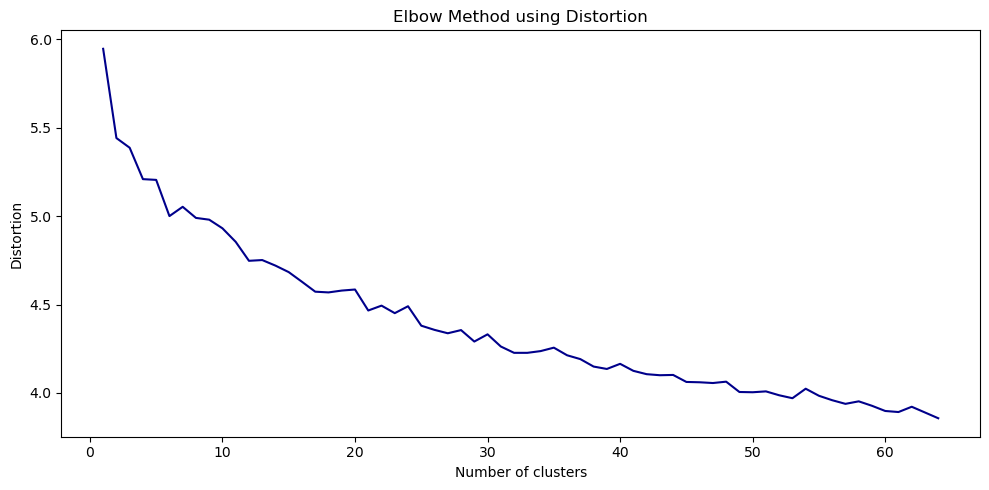

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(kmeans_df['Clusters'], kmeans_df['Distortion'], marker='', linestyle='-', color='darkblue')
plt.title('Elbow Method using Distortion')
plt.ylabel('Distortion')
plt.xlabel('Number of clusters')

plt.tight_layout()
plt.show()

Based on this graph, using the elbow method we can infer that the elbow could be located at 12 clusters. Even though 19, 21, or 23 clusters also could be good solutions, DBSCAN gives a similar answer (5 or 13 clusters being the two best options). Thus, we will use 12 clusters for k-means++.

## DBSCAN
For DBSCAN due to my laptops computational limitations, we used the dimensionality reduced data obtained from PCA (which explained more than 90% of the variance and held 25 out of the original 71 variables). We used Davies Boulding Index as our score due to its computational simplicity and its easy readability. We ran the algorithm with different values for epsilon and minimum samples. The algorithm took 1.5 hours to run, which is a long time, but it is a good result considering the size of the data set.

In [1]:
import numpy as np
import pandas as pd

scores_pca_df=pd.read_csv('../../data/Clean_Data_project_Pub.Transport_5000/scores_pca.csv')

These are the results:

In [19]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import davies_bouldin_score
import numpy as np

l_eps = np.arange(0.5, 2, 0.1)
n_sample = range(5, 11)

results = {}

for eps in l_eps:
    best_db_index = float('inf')
    opt_sample = None
    opt_num_clusters = None

    for n in n_sample:
        model = DBSCAN(eps=eps, min_samples=n).fit(scores_pca_df)
        try:
            unique_labels = np.unique(model.labels_)
            if len(unique_labels) > 1 or (len(unique_labels) == 1 and unique_labels[0] != -1):
                db_score = davies_bouldin_score(scores_pca_df, model.labels_)
                num_clusters = len(unique_labels) - 1 
                
                if db_score < best_db_index:
                    best_db_index = db_score
                    opt_sample = n
                    opt_num_clusters = num_clusters
        except:
            continue
    
    results[eps] = {
        'min_samples': opt_sample,
        'db_index': best_db_index,
        'num_clusters': opt_num_clusters
    }

print("Results for each epsilon value:")
for eps, values in results.items():
    print(f"For epsilon={eps}: Min_samples={values['min_samples']}, Davies-Bouldin Index={values['db_index']}, Number of Clusters={values['num_clusters']}")

Results for each epsilon value:
For epsilon=0.5: Min_samples=10, Davies-Bouldin Index=0.5465900750864565, Number of Clusters=5
For epsilon=0.6: Min_samples=10, Davies-Bouldin Index=1.0735197191834835, Number of Clusters=13
For epsilon=0.7: Min_samples=10, Davies-Bouldin Index=1.2753967110181181, Number of Clusters=24
For epsilon=0.7999999999999999: Min_samples=10, Davies-Bouldin Index=1.2865395597058111, Number of Clusters=24
For epsilon=0.8999999999999999: Min_samples=9, Davies-Bouldin Index=1.4075326833557051, Number of Clusters=32
For epsilon=0.9999999999999999: Min_samples=10, Davies-Bouldin Index=1.701066737957798, Number of Clusters=50
For epsilon=1.0999999999999999: Min_samples=5, Davies-Bouldin Index=1.7688572327797196, Number of Clusters=311
For epsilon=1.1999999999999997: Min_samples=5, Davies-Bouldin Index=1.683123753663869, Number of Clusters=296
For epsilon=1.2999999999999998: Min_samples=8, Davies-Bouldin Index=1.6238516834146322, Number of Clusters=68
For epsilon=1.4: Mi

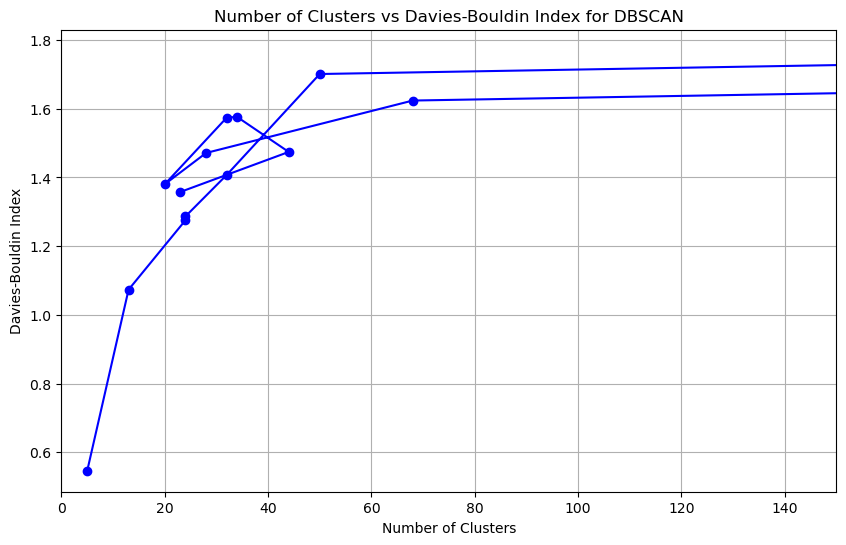

In [26]:
num_clusters_values = [result['num_clusters'] for result in results.values()]
db_index_values = [result['db_index'] for result in results.values()]

plt.figure(figsize=(10, 6))
plt.plot(num_clusters_values, db_index_values, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Number of Clusters vs Davies-Bouldin Index for DBSCAN')
plt.grid(True)
plt.xlim(0, 150)
plt.show()

Based on this results, we see that the first two best results are 5 and 13 clusters. As we can see that 13 clusters is still a good result based on the Davies Boulding Index, we will keep this in mind as it is more similar to the result also obtained in K-means++.

## Hierarchical clustering
Due to the elevated computational complexity of this method, as k-means and DBSCAN already gave us good results, we will run Hierarchical clustering using 12 clusters as the number of clusters. We will use the same dimensionality reduced data obtained from PCA, but downsampled. The sampling was done using the stratified sampling method, which is a method that ensures that the sample is representative of the population and would better represent the data set (in order to properly assess clustering). Finally, the sample was only 20% of the original data set, which is still a large enough sample to be representative of the population.

In [ ]:
import pandas as pd
scores_pca_df=pd.read_csv('../../data/Clean_Data_project_Pub.Transport_5000/scores_pca.csv')

In [ ]:
import pandas as pd

scores_pca_df.iloc[:, 0] = pd.to_numeric(scores_pca_df.iloc[:, 0], errors='coerce')

min_col1 = scores_pca_df.iloc[:, 0].min(skipna=True)
max_col1 = scores_pca_df.iloc[:, 0].max(skipna=True)
print(f"Min value of the first column: {min_col1}")
print(f"Max value of the first column: {max_col1}")

In [ ]:
for_samples = scores_pca_df

breakpoints = [-float('inf'), -14.93975, 11.2275, 37.39475, 63.562, 89.72925, 115.8965, 142.06375, 168.231, 194.39825, 220.5655, 246.73275, float('inf')]

for_samples['labels'] = pd.cut(for_samples.iloc[:, 0], bins=breakpoints, labels=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L'])

stratified_sample = for_samples.groupby('labels', group_keys=False).apply(lambda x: x.sample(frac=0.2))

stratified_sample_no_lab = stratified_sample.drop(columns=['labels'])

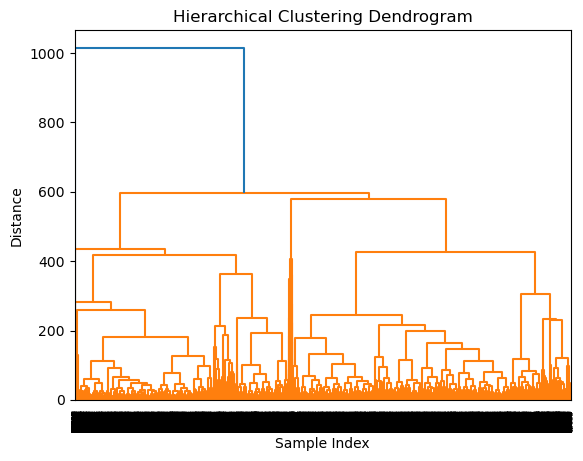

Davies-Bouldin Index: 1.4871933145528213
         Feature_1  Feature_2  Cluster
24683   -17.298789  22.884256       10
25006   -18.274415  25.452802       10
30365    -2.575073   3.024186        0
38241     2.206078  -2.983790       11
128967   -1.500392   1.324897        0
...            ...        ...      ...
150094   97.759211  26.286094        8
209124   92.407836  32.282488        9
152816  107.218005  44.218345        8
42838   117.086261  64.029969        8
16705   160.011595  -3.324794        7

[44149 rows x 3 columns]


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage

linkage_matrix = linkage(stratified_sample_no_lab, method='ward')

dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

num_clusters = 12
labels = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward').fit_predict(stratified_sample_no_lab)

db_index = davies_bouldin_score(stratified_sample_no_lab, labels)
print(f'Davies-Bouldin Index: {db_index}')

result_df = pd.DataFrame({
    'Feature_1': stratified_sample_no_lab['PC1'],
    'Feature_2': stratified_sample_no_lab['PC2'],
    'Cluster': labels
})

print(result_df)



For the results, Feature_1 and Feature_2 are the coordinates of the data points based on the first two features. Furthermore, a Davies Boulding Index of less than 1.5 is a good result for this data set, which is a good indication for this number of clusters. The results also indicate the cluster to which each data point has been assigned to. Finally, the dendogram also allow us to understand better the distribution of the data points and the clusters in a more visual way.

## Conclusion

Based on the results obtained from the three methods, we have a good reason to believe that clusters exist. However, due to our computational constrains encountered and the great size of our data set (in terms of variables), it will be helpful to visualize the clusters in 2D based on different variables. Firstly, we will visualize them on handpicked variables that we believe are the most explanatory from the primary data set. Then, we will use the PCA's reduced data set to visualize the clusters in 2D from the first ten variables. Finally, we will make our inferences based on what we can see from the graphs.

### Visualization of the clusters of the primary data set



The following code adds the clusters to the data set and plots every pair of the following variables: 'CBSA_POP', 'Ac_Water', 'Ac_Land', 'TotPop', 'P_WrkAge', 'E_HiWageWk', 'AutoOwn0', 'NatWalkInd', 'E_MedWageWk', 'Ac_Unpr'. These have been selected due to their importance when describing a census block and due to easy human interpretability. The objective is to see if there are any patterns in the clusters that can be used to make generalizations about the census blocks.

Note: Only 60% of the data set was used for this visualization due to the computational limitations of my laptop. However, it has been sampled using the stratified sampling method, which ensures that the sample is representative of the population.

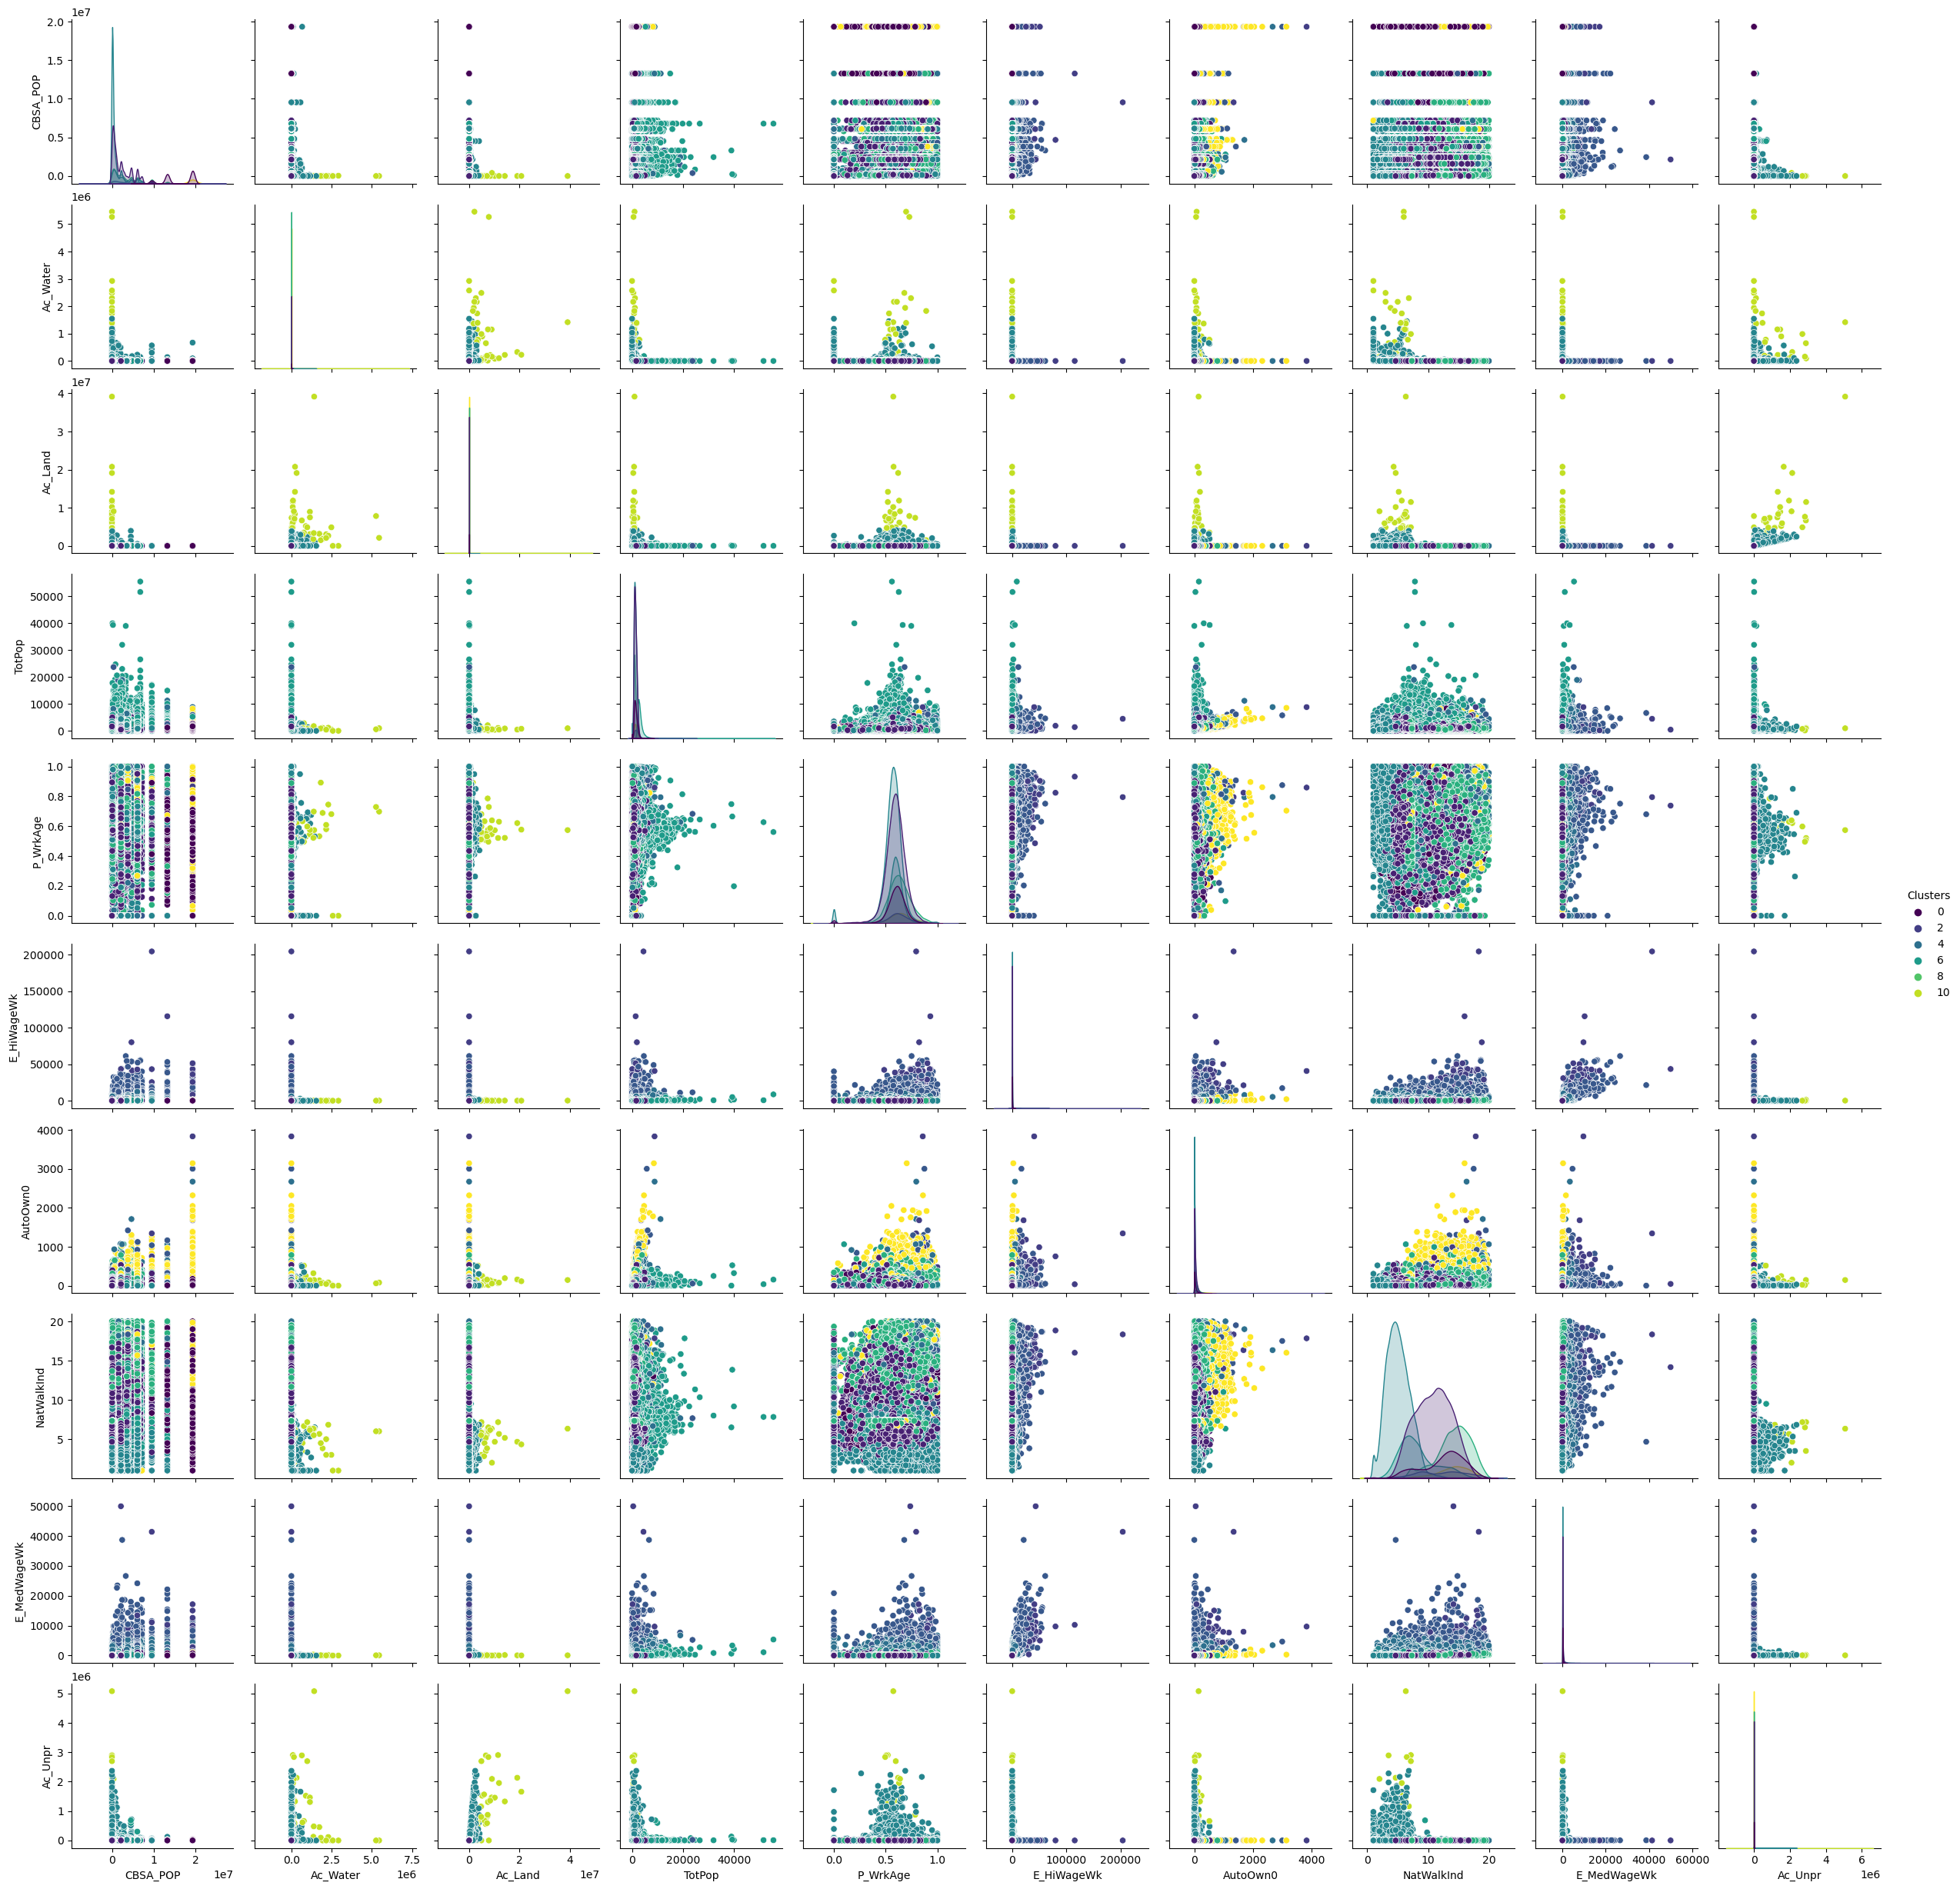

In [8]:
warnings.filterwarnings('ignore')

df= pd.read_csv("../../data/Clean_Data_project_Pub.Transport_5000/EPA_SmartLocationDatabase_V3_Jan_2021_Clean.csv")
scaler = StandardScaler()
df_scaled = (scaler.fit_transform(df))

kmeans = KMeans(n_clusters=12, random_state=42)
df['Clusters'] = kmeans.fit_predict(df_scaled)

columns_to_plot = ['CBSA_POP', 'Ac_Water', 'Ac_Land', 'TotPop', 'P_WrkAge', 'E_HiWageWk', 'AutoOwn0', 'NatWalkInd', 'E_MedWageWk', 'Ac_Unpr']

sns.pairplot(df, vars=columns_to_plot, hue='Clusters', palette='viridis')
plt.show()

The previous pairplot is very interesting. While in some pairs of the variables there is a complete overlap of the clusters, in others, we can really see the separation of these. Ac_Land and AC_Unpr, TotPop and AC_Land, AC_Land and P_wrkAge, P_wrkAge and AC_Unpr, and AC_Water and E_MedWage are great visualizations for this. This is a good sign that there seems to be clusters in our data set that are human interpretable and can be used to make generalizations about the census blocks.

### Visualization of the clusters of the PCA data set

The following code adds the clusters to the PCA data set and plots every pair of the first ten variables of the PCA data set. A new csv file has been created (pca_clustered_data.csv) for reproducibility purposes. The objective is to see if there are any patterns in the clusters that can be used to make generalizations about the census blocks and compare the results with the previous pairplots.

Note: Only 60% of the data set was used for this visualization due to the computational limitations of my laptop. However, it has been sampled using the stratified sampling method, which ensures that the sample is representative of the population.

In [ ]:
df_pca=pd.read_csv('../../data/Clean_Data_project_Pub.Transport_5000/scores_pca.csv')

num_clusters = 12

features = df_pca.iloc[:, :]

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_pca['Cluster'] = kmeans.fit_predict(features)

df_pca.to_csv('../../data/Clean_Data_project_Pub.Transport_5000/pca_clustered_data.csv', index=False)

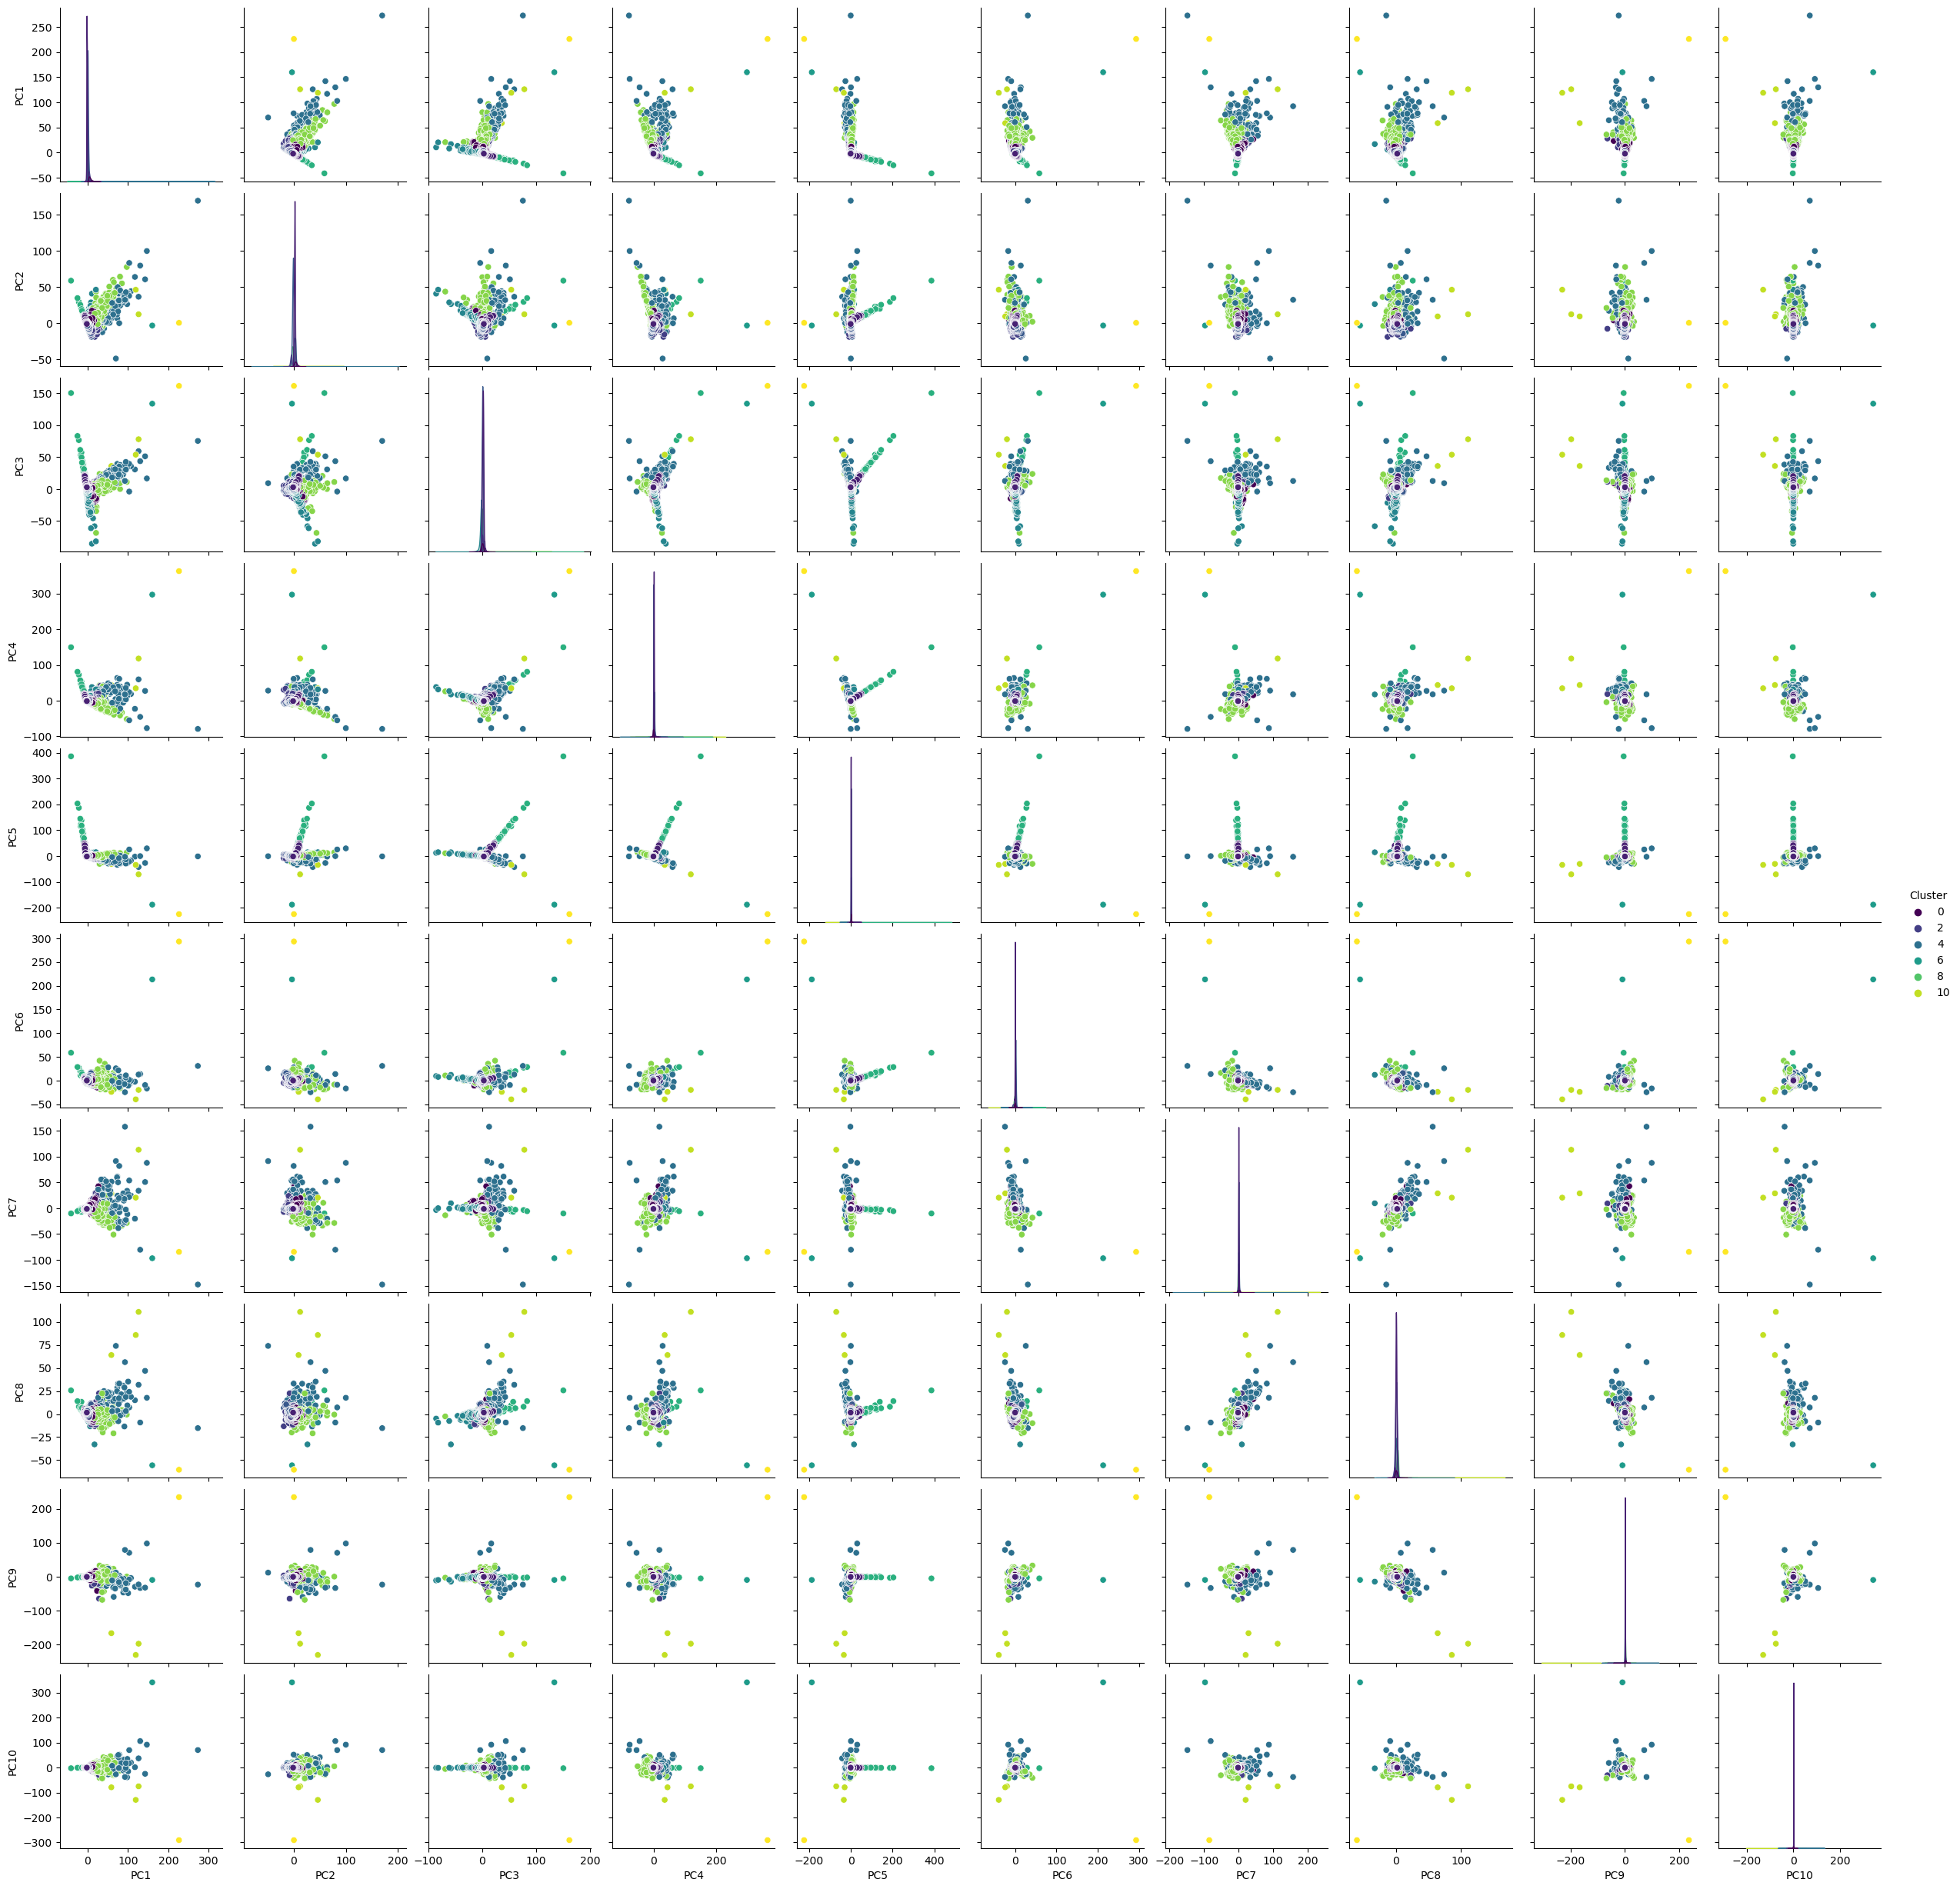

In [9]:
warnings.filterwarnings('ignore')

df_pca= pd.read_csv("../../data/Clean_Data_project_Pub.Transport_5000/pca_clustered_data.csv")

columns_to_plot = df_pca.columns[:10]

sns.pairplot(df_pca, vars=columns_to_plot, hue='Cluster', palette='viridis')

plt.show()

The following pairplot is very interesting. While in some pairs of the variables there is a complete overlap of the clusters, in others, we can really see the separation of these. PC8 and PC5, PC3 and PC5, and PC5 and PC4 are great visualizations for this. This is a good sign that there seems to be clusters in our data set that are human interpretable and can be used to make generalizations about the census blocks.

### Final Conclusion
We can determine that there seems to be possible clustering in the data set. With more advance computational power, it could be determined with more precision. However, with the methods utilized, we can determine that there are probably 12 clusters in the data set. Not only the clustering scores support this claim, but the pairplots really display good indications that this is the case. These clusters could be used to make generalizations about the census blocks and use them for public transportation planning.